# Preparation 

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['playbyplay_2012', 'playbyplay_2015', 'playbyplay_2018', 'playbyplay_2017', 'datafiles', 'playbyplay_2010', 'SampleSubmissionStage1.csv', 'playbyplay_2013', 'playbyplay_2014', 'playbyplay_2016', 'masseyordinals', 'playbyplay_2011']


In [2]:
# Import packages
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.utils import shuffle 
from sklearn.model_selection import GridSearchCV

In [3]:
# Show the list of files in the input directory 
from subprocess import check_output
print(check_output(["ls","../input"]).decode("utf8"))

SampleSubmissionStage1.csv
datafiles
masseyordinals
playbyplay_2010
playbyplay_2011
playbyplay_2012
playbyplay_2013
playbyplay_2014
playbyplay_2015
playbyplay_2016
playbyplay_2017
playbyplay_2018



# Training Data Loading

Tourney seeds and Compact results are used for simplicity 

In [4]:
data_directory = '../input/'
df_seeds = pd.read_csv(data_directory + 'datafiles/NCAATourneySeeds.csv')
df_tour = pd.read_csv(data_directory + 'datafiles/NCAATourneyCompactResults.csv')

In [5]:
df_seeds.head()

,Season,Seed,TeamID
0,1985,W01,1207
1,1985,W02,1210
2,1985,W03,1228
3,1985,W04,1260
4,1985,W05,1374


In [6]:
df_tour.head()

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0
3,1985,136,1229,58,1425,55,N,0
4,1985,136,1242,49,1325,38,N,0


Simplify the data set

In [7]:
def seed_to_int(seed):
    s_int = int(seed[1:3])
    return s_int
df_seeds['seed_int'] = df_seeds.Seed.apply(seed_to_int)
df_seeds.drop(labels = ['Seed'], inplace = True, axis = 1)
df_seeds.head()

,Season,TeamID,seed_int
0,1985,1207,1
1,1985,1210,2
2,1985,1228,3
3,1985,1260,4
4,1985,1374,5


In [8]:
df_tour.drop(labels = ['DayNum', 'WScore', 'LScore', 'WLoc', 'NumOT'], inplace = True, axis = 1)
df_tour.head()

,Season,WTeamID,LTeamID
0,1985,1116,1234
1,1985,1120,1345
2,1985,1207,1250
3,1985,1229,1425
4,1985,1242,1325


# Merge seed for each team

Merge the seeds with their corresponding TeamIDs in the compact results dataframe 

In [9]:
df_winseeds = df_seeds.rename(columns = {'TeamID':'WTeamID', 'seed_int':'WSeed'})
df_lossseeds = df_seeds.rename(columns = {'TeamID':'LTeamID', 'seed_int':'LSeed'})
df_dummy = pd.merge(left = df_tour, right = df_winseeds, how = 'left', on = ['Season', 'WTeamID'])
df_concat = pd.merge(left = df_dummy, right = df_lossseeds, on = ['Season', 'LTeamID'])
df_concat['SeedDiff'] = df_concat.WSeed - df_concat.LSeed
df_concat.head()

,Season,WTeamID,LTeamID,WSeed,LSeed,SeedDiff
0,1985,1116,1234,9,8,1
1,1985,1120,1345,11,6,5
2,1985,1207,1250,1,16,-15
3,1985,1229,1425,9,8,1
4,1985,1242,1325,3,14,-11


Summarize wins and losses along with the corresponding seed differences 

In [10]:
df_wins = pd.DataFrame()
df_wins['SeedDiff'] = df_concat['SeedDiff']
df_wins['Result'] = 1

df_losses = pd.DataFrame()
df_losses['SeedDiff'] = -df_concat['SeedDiff']
df_losses['Result'] = 0

df_predictions = pd.concat((df_wins, df_losses))
df_predictions.head()

,SeedDiff,Result
0,1,1
1,5,1
2,-15,1
3,1,1
4,-11,1


In [11]:
X_train = df_predictions.SeedDiff.values.reshape(-1,1)
y_train = df_predictions.Result.values
X_train, y_train = shuffle(X_train, y_train)

# Model training

In [12]:
Using logistic regression 

SyntaxError: invalid syntax (<ipython-input-12-5493740934ac>, line 1)

In [13]:
logreg = LogisticRegression()
params = {'C':np.logspace(start = -5, stop = 3, num = 9)}
clf = GridSearchCV(logreg, params, scoring = 'neg_log_loss', refit = True)

clf.fit(X_train, y_train)
print('Best_log_loss:{:.4}, with best C:{}'.format(clf.best_score_, clf.best_params_['C']))

Best_log_loss:-0.5548, with best C:0.01


/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be change

Text(0,0.5,'P(Team1 will win)')

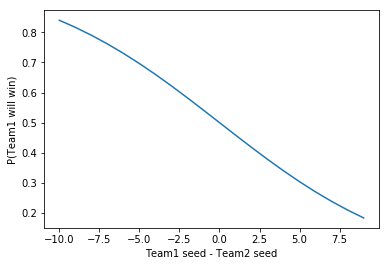

In [14]:
X = np.arange(-10, 10).reshape(-1,1)
preds = clf.predict_proba(X)[:,1]

plt.plot(X, preds)
plt.xlabel('Team1 seed - Team2 seed')
plt.ylabel('P(Team1 will win)')

the probability a team will win decreases as the seed differential to its opponent decreases.

In [15]:
df_sample_sub = pd.read_csv(data_directory + 'SampleSubmissionStage1.csv')
n_test_games = len(df_sample_sub)

def get_year_t1_t2(ID):
    return(int(x) for x in ID.split('_'))

In [16]:
X_test = np.zeros(shape = (n_test_games, 1))

for ii, row in df_sample_sub.iterrows():
    year, t1, t2 = get_year_t1_t2(row.ID)
    t1_seed = df_seeds[(df_seeds.TeamID == t1) & (df_seeds.Season == year)].seed_int.values[0]
    t2_seed = df_seeds[(df_seeds.TeamID == t2) & (df_seeds.Season == year)].seed_int.values[0]
    diff_seed = t1_seed - t2_seed
    X_test[ii,0] = diff_seed

# Make predictions 

In [17]:
create predictions using logistic regression trained 

SyntaxError: invalid syntax (<ipython-input-17-da131a1b07fe>, line 1)

In [18]:
preds = clf.predict_proba(X_test)[:,1]

clipped_preds = np.clip(preds, 0.05, 0.95)
df_sample_sub.Pred = clipped_preds
df_sample_sub.head()

,ID,Pred
0,2014_1107_1110,0.458571
1,2014_1107_1112,0.076459
2,2014_1107_1113,0.269613
3,2014_1107_1124,0.159631
4,2014_1107_1140,0.269613


In [19]:
create the submission file 

SyntaxError: invalid syntax (<ipython-input-19-6195b91a1626>, line 1)

In [20]:
df_sample_sub.to_csv('Logreg_seed_starter.csv', index = False)